Estimated Variance: 1.1695
Estimated Transmittance: 1.0843
Estimated SNR: 5.4214
Bit Error Rate (BER) after repetition coding: 0.0070
Final Shared Key (SHA-256): 69ab211c4c71cab30ae9fe73f8398cb04efa58df1b2a939f1799c74c5a240b70


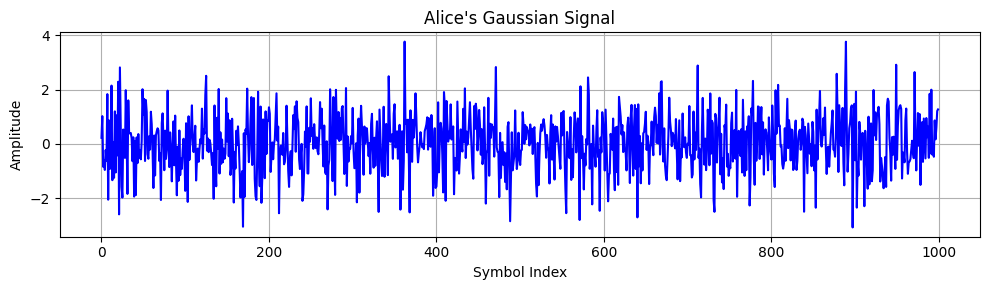

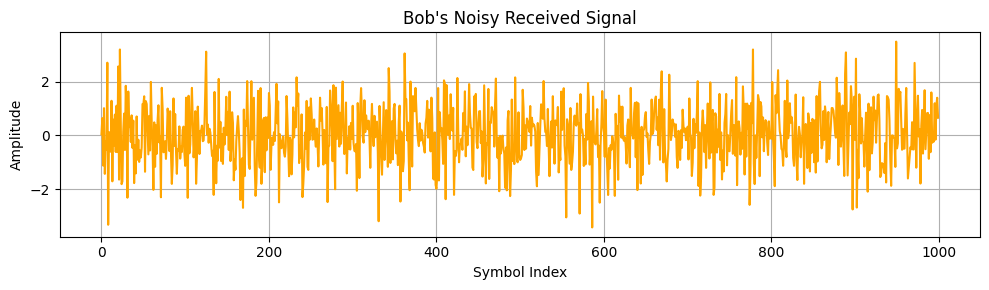

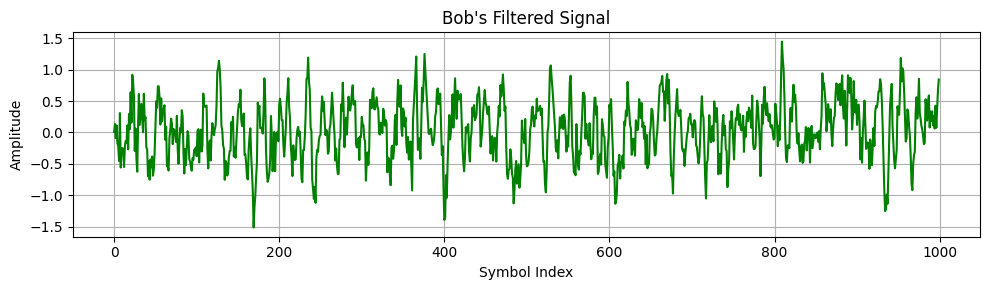

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, welch
from hashlib import sha256

np.random.seed(25)

N = 1000
variance = 1.0
channel_transmittance = 0.9
noise_variance = 0.2
filter_len = 5
repetition_factor = 5
flip_prob = 0.1

def generate_gaussian_signal(N, variance):
    return np.random.normal(0, np.sqrt(variance), size=N)

def quantum_channel(signal, transmittance, noise_var):
    return np.sqrt(transmittance) * signal + np.random.normal(0, np.sqrt(noise_var), size=signal.shape)

def matched_filter(signal, length=5):
    filt = np.ones(length) / length
    return lfilter(filt, 1.0, signal)

def quantize(signal):
    return (signal > 0).astype(int)

def estimate_parameters(alice, bob, noise_var):
    est_var = np.var(bob)
    est_trans = est_var / np.var(alice)
    est_snr = est_trans / noise_var
    return est_var, est_trans, est_snr

def calculate_ber(bits1, bits2):
    return np.mean(bits1 != bits2)

def privacy_amplification(bits):
    bit_str = ''.join(str(b) for b in bits)
    return sha256(bit_str.encode()).hexdigest()

# ------------ Encoding & Decoding -------------
def repetition_encode(bits, r):
    return np.repeat(bits, r)

def simulate_bit_flip(bits, p):
    flips = np.random.rand(len(bits)) < p
    return np.bitwise_xor(bits, flips.astype(int))

def repetition_decode(bits, r):
    reshaped = bits[:len(bits)//r*r].reshape(-1, r)
    decoded = np.round(np.mean(reshaped, axis=1)).astype(int)
    return decoded

# -------------------- MAIN PIPELINE --------------------

# Alice Signal
alice_signal = generate_gaussian_signal(N, variance)

# Bob Signal
bob_signal = quantum_channel(alice_signal, channel_transmittance, noise_variance)
bob_filtered = matched_filter(bob_signal, filter_len)

# Parameter Estimation
est_var, est_trans, est_snr = estimate_parameters(alice_signal, bob_signal, noise_variance)
print(f"Estimated Variance: {est_var:.4f}")
print(f"Estimated Transmittance: {est_trans:.4f}")
print(f"Estimated SNR: {est_snr:.4f}")

# Quantization
alice_bits = quantize(alice_signal)
bob_bits = quantize(bob_filtered)

# ------------- Encode & Transmit ---------------
encoded = repetition_encode(alice_bits, repetition_factor)
transmitted = simulate_bit_flip(encoded, flip_prob)
decoded_bits = repetition_decode(transmitted, repetition_factor)

# Error Analysis
ber = calculate_ber(alice_bits[:len(decoded_bits)], decoded_bits)
print(f"Bit Error Rate (BER) after repetition coding: {ber:.4f}")

# Privacy Amplification
secret_key = privacy_amplification(decoded_bits)
print(f"Final Shared Key (SHA-256): {secret_key}")

# -------------------Visualization--------------------

def plot_signal(signal, title, color='blue'):
    plt.figure(figsize=(10, 3))
    plt.plot(signal, color=color)
    plt.title(title)
    plt.xlabel("Symbol Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_histograms(alice, bob):
    plt.figure(figsize=(8, 4))
    plt.hist(alice, bins=40, alpha=0.6, label="Alice")
    plt.hist(bob, bins=40, alpha=0.6, label="Bob")
    plt.title("Signal Distribution")
    plt.xlabel("Amplitude")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_ber_locations(bits1, bits2):
    errors = (bits1[:len(bits2)] != bits2).astype(int)
    plt.figure(figsize=(10, 2))
    plt.plot(errors, '|', color='red')
    plt.title("Bit Error Locations After Decoding")
    plt.xlabel("Bit Index")
    plt.ylabel("Error")
    plt.tight_layout()
    plt.show()

def plot_psd(signal, fs=1.0):
    f, Pxx = welch(signal, fs=fs)
    plt.figure(figsize=(8, 3))
    plt.semilogy(f, Pxx)
    plt.title("Power Spectral Density")
    plt.xlabel("Frequency")
    plt.ylabel("PSD")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Visuals
plot_signal(alice_signal, "Alice's Gaussian Signal")
plot_signal(bob_signal, "Bob's Noisy Received Signal", color='orange')
plot_signal(bob_filtered, "Bob's Filtered Signal", color='green')

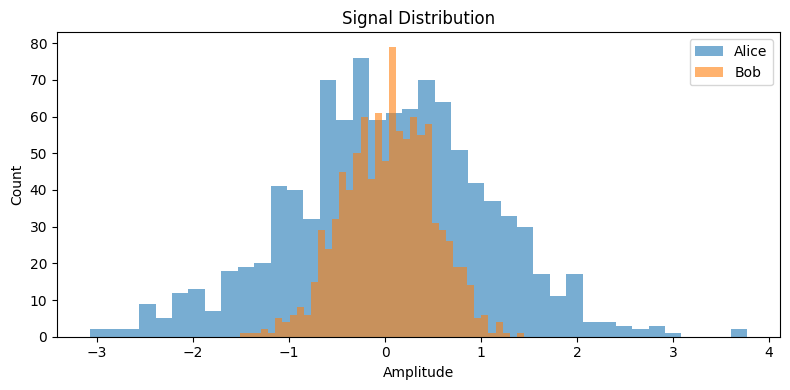

In [ ]:
plot_histograms(alice_signal, bob_filtered)

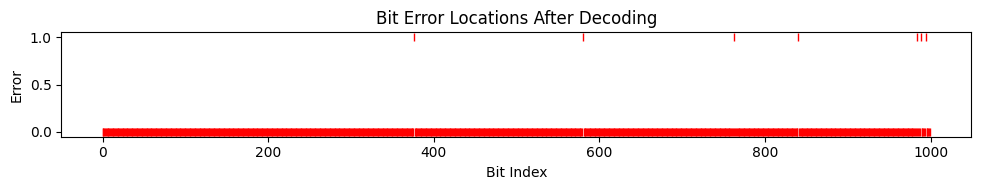

In [ ]:
plot_ber_locations(alice_bits, decoded_bits)

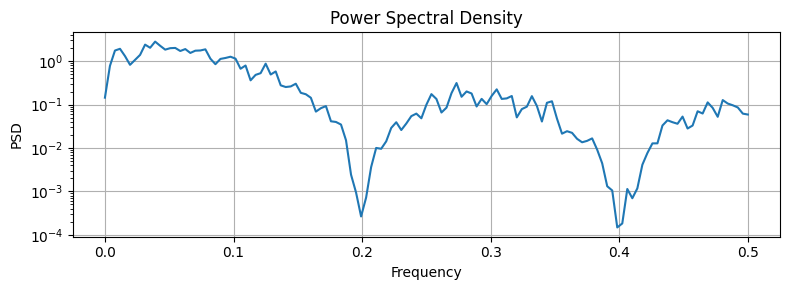

In [ ]:
plot_psd(bob_filtered)